<a href="https://colab.research.google.com/github/danielf-moralesp20/neural-network-projects/blob/main/handwritten-digit-recognizer/handwritten-digit-recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.metrics import classification_report
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling, Resizing, Input
from tensorflow.keras.models import Sequential
from tensorflow.math import confusion_matrix
from tensorflow.python.framework.ops import enable_eager_execution

enable_eager_execution()

# Data loading

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'mnist',
    split=['train[:80%]+test[:80%]', 'train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [3]:
print('Image dimensions: ' + str(metadata.features['image'].shape))
print('Image type: ' + str(metadata.features['image'].dtype), end='\n\n')

print('Number of classes: ' + str(metadata.features['label'].num_classes))

Image dimensions: (28, 28, 1)
Image type: <dtype: 'uint8'>

Number of classes: 10


# Data overview

In [4]:
tfds.as_dataframe(train_ds.take(7), metadata)

,image,label
0,,2
1,,4
2,,1
3,,0
4,,7
5,,8
6,,1


(-0.5, 27.5, 27.5, -0.5)

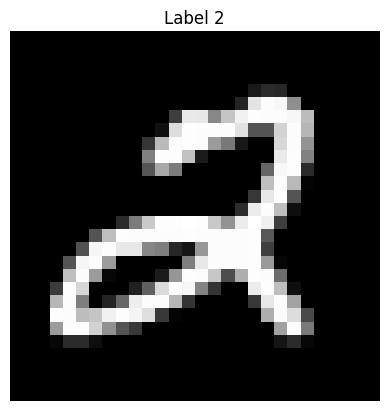

In [5]:
image, label = next(iter(train_ds))

plt.imshow(image, cmap='gray')
plt.title('Label ' + str(label.numpy()))
plt.axis('off')

# Data preprocessing

In [6]:
IMG_SIZE = 28

resize_and_rescale = Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./255)
])

def img_preprocessing(image, label):
  image = tf.cast(image, tf.float32)
  image = resize_and_rescale(image)

  return image, label


In [7]:
train_ds = train_ds.map(img_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(img_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(img_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
train_ds_count = train_ds.cardinality().numpy()
train_ds = train_ds.shuffle(train_ds_count)

# Dataset optimization

In [9]:
BATCH_SIZE = 32

train_ds = train_ds.cache()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Estimator build

In [10]:
checkpoint_path = "tmp/checkpoint"

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model_checkpoint = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, mode='min', save_weights_only=True, verbose=1
)

In [11]:
estimator = Sequential([
    Input(metadata.features['image'].shape),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, 'relu'),
    Dropout(0.5),
    Dense(200, 'relu'),
    Dropout(0.5),
    Dense(10, 'softmax'),
])

estimator.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

if os.path.exists(checkpoint_path): estimator.load_weights(checkpoint_path)

In [12]:
estimator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)       

In [13]:
estimator.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=[early_stop, model_checkpoint])

Epoch 1/150
1750/1750 [==============================] - ETA: 0s - loss: 0.3217
Epoch 1: val_loss improved from inf to 0.06972, saving model to tmp/checkpoint
1750/1750 [==============================] - 149s 78ms/step - loss: 0.3217 - val_loss: 0.0697
Epoch 2/150
1750/1750 [==============================] - ETA: 0s - loss: 0.1004
Epoch 2: val_loss improved from 0.06972 to 0.04624, saving model to tmp/checkpoint
1750/1750 [==============================] - 133s 76ms/step - loss: 0.1004 - val_loss: 0.0462
Epoch 3/150
1750/1750 [==============================] - ETA: 0s - loss: 0.0750
Epoch 3: val_loss improved from 0.04624 to 0.04322, saving model to tmp/checkpoint
1750/1750 [==============================] - 136s 78ms/step - loss: 0.0750 - val_loss: 0.0432
Epoch 4/150
1750/1750 [==============================] - ETA: 0s - loss: 0.0609
Epoch 4: val_loss improved from 0.04322 to 0.03340, saving model to tmp/checkpoint
1750/1750 [==============================] - 131s 75ms/step - loss: 0.

# Estimator validation performance

<Axes: >

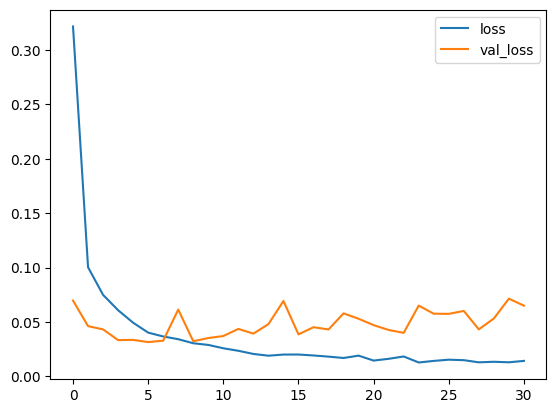

In [14]:
estimator_loss = pd.DataFrame(estimator.history.history)
estimator_loss.plot()  

In [15]:
y_hat_val = estimator.predict(val_ds)
y_hat_val = y_hat_val.argmax(axis=1)

y_true_val = tf.concat([label for _, label in val_ds], axis=0).numpy()

219/219 [==============================] - 8s 34ms/step


In [16]:
confusion_matrix(y_true_val, y_hat_val)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[692,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0, 792,   1,   0,   0,   0,   1,   0,   0,   1],
       [  1,   0, 693,   0,   0,   0,   0,   3,   0,   0],
       [  1,   0,   2, 679,   0,   3,   0,   2,   0,   1],
       [  0,   1,   0,   0, 671,   0,   0,   1,   0,   3],
       [  2,   0,   0,   0,   0, 582,   5,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0, 721,   0,   0,   0],
       [  0,   3,   2,   1,   0,   0,   0, 728,   0,   2],
       [  1,   1,   2,   2,   1,   4,   5,   0, 678,   3],
       [  0,   0,   0,   2,   1,   0,   0,   5,   0, 698]], dtype=int32)>

In [17]:
print(classification_report(y_true_val, y_hat_val))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       693
           1       0.99      1.00      0.99       795
           2       0.99      0.99      0.99       697
           3       0.99      0.99      0.99       688
           4       1.00      0.99      0.99       676
           5       0.99      0.99      0.99       589
           6       0.98      1.00      0.99       723
           7       0.99      0.99      0.99       736
           8       1.00      0.97      0.99       697
           9       0.99      0.99      0.99       706

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000



#Estimator test performance

In [18]:
y_hat_test = estimator.predict(test_ds)
y_hat_test = y_hat_test.argmax(axis=1)

y_true_test = tf.concat([label for _, label in test_ds], axis=0).numpy()

219/219 [==============================] - 5s 20ms/step


In [19]:
confusion_matrix(y_true_test, y_hat_test)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[489,  21,  16,  25,  19,  22,  21,  14,  16,  16],
       [ 15, 600,  19,  21,  22,  18,  17,  26,  22,  26],
       [ 19,  21, 521,  24,  16,  20,  20,  18,  12,  20],
       [ 27,  28,  23, 533,  13,  32,  19,  19,  14,  21],
       [ 16,  14,  24,  21, 511,  17,  21,  25,  26,  33],
       [ 25,  20,  22,  19,  19, 484,  24,  17,  15,  23],
       [ 14,  18,  12,  16,  21,  23, 504,  23,  18,  17],
       [ 14,  23,  24,  22,  23,  17,  13, 554,  24,  19],
       [ 16,  19,  23,  20,  28,  21,  23,  11, 502,  11],
       [ 24,  17,  17,  19,  27,  17,  16,  27,  11, 511]], dtype=int32)>

In [20]:
print(classification_report(y_true_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       659
           1       0.77      0.76      0.77       786
           2       0.74      0.75      0.75       691
           3       0.74      0.73      0.74       729
           4       0.73      0.72      0.73       708
           5       0.72      0.72      0.72       668
           6       0.74      0.76      0.75       666
           7       0.75      0.76      0.76       733
           8       0.76      0.74      0.75       674
           9       0.73      0.74      0.74       686

    accuracy                           0.74      7000
   macro avg       0.74      0.74      0.74      7000
weighted avg       0.74      0.74      0.74      7000



# Estimator storage

In [21]:
json_estimator = estimator.to_json()

with open('estimator_result.json', 'w') as json_file:
    json_file.write(json_estimator)